# HPF SNR Plots

This notebook contains scripts to make SNR plots for HPF, which can be used to calculate expected SNRs for

- a) Best-case seeing conditions and peak tracks
- b) Median case seeing conditions / slightly off peak track

A few further notes:

- This uses engineering data from HPF engineering runs
- All SNRs are 1D extracted SNRs evaluated at Order 18 (counting from 0), which corresponds roughly to 1.07micron
- Fluxes are in electrons

In [1]:
from __future__ import print_function
import sys
sys.path.append("../src")
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import glob
import pandas as pd

# matplotlib
import seaborn as sns; sns.set()
sns.set_context("poster",font_scale=1.2,rc={"font":"helvetica"}); 
sns.set_style("white")
cp = sns.color_palette("colorblind") 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["savefig.dpi"] = 150
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['font.weight'] = "normal"
rcParams["axes.formatter.useoffset"] = False
rcParams['xtick.major.width']=1
rcParams['xtick.major.size']=7
rcParams['xtick.minor.width']=1
rcParams['xtick.minor.size']=4
rcParams['ytick.major.width']=1
rcParams['ytick.major.size']=7
rcParams['ytick.minor.width']=1
rcParams['ytick.minor.size']=4

## Read in some on-sky data from HPF engineering runs at HET

In [5]:
df = pd.read_csv('../data/on_sky_snr.csv')
df

,jmag,sn18_best,sn18_med,flux18_best,flux18_med,exptime_best,exptime_med
0,3.4,621.959094,535.597711,555561.461514,402235.703715,52.4288,52.42880
1,3.6,655.340565,546.165533,626612.409720,423039.604454,52.4288,52.42880
2,5.2,715.955242,464.809404,700208.863509,265774.373652,314.5728,314.57280
3,6.9,380.727862,256.285517,181970.545796,88329.610033,314.5728,314.57280
4,8.8,161.232867,112.034911,32864.490271,15938.572610,314.5728,314.57280
5,9.8,143.903730,91.194801,25911.814827,10747.154627,629.1456,314.57280
6,10.8,78.639397,57.479331,8188.527080,5129.519406,943.7184,943.71840
7,11.3,73.661442,63.683887,7230.390356,5397.632260,943.7184,922.74688


In [9]:
# Define two columns containing the flux slopes in electrons/s
df['slope18_best'] = df.flux18_best/df.exptime_best
df['slope18_med']  = df.flux18_med/df.exptime_med

## Fitting HPF Flux slope as a function of magnitude

We'll describe the HPF flux slope in the following functional format:

$$ f = 10^{-0.4(m-m_{\mathrm{ref}})},$$

where $f$ is the flux slope in electrons per second, and $m$ is the J-band magnitude, and $m_{ref}$ is the reference magnitude that we want to fit for. We'll do that for two cases, the best-case we have observed with HPF and the median case (in dataframe).

Let's define a few useful functions first.

In [25]:
import scipy.optimize

def slope_model(mref,m):
    """
    Returns the HPF flux in electrons / s.
    
    INPUT: 
        mref: constant reference magnitude (to be fitted)
        m: J-magnitude
        
    OUTPUT:
        flux slope (electrons/s)
    """
    return 10**(-0.4*(m-mref))

def res_func(mref,m,observed_slope):
    """Simple residual function for fitting"""
    return observed_slope - slope_model(mref,m)

def fit_slope(m,observed_slope):
    """
    Returns the best fit mref in the slope model
    """
    mref = scipy.optimize.leastsq(res_func,x0=0.1,args=(m,observed_slope))[0][0]
    return mref

### Plot best fit slope

Best-fit Constant mref for best case = 13.61
Best-fit Constant mref for median case = 13.21


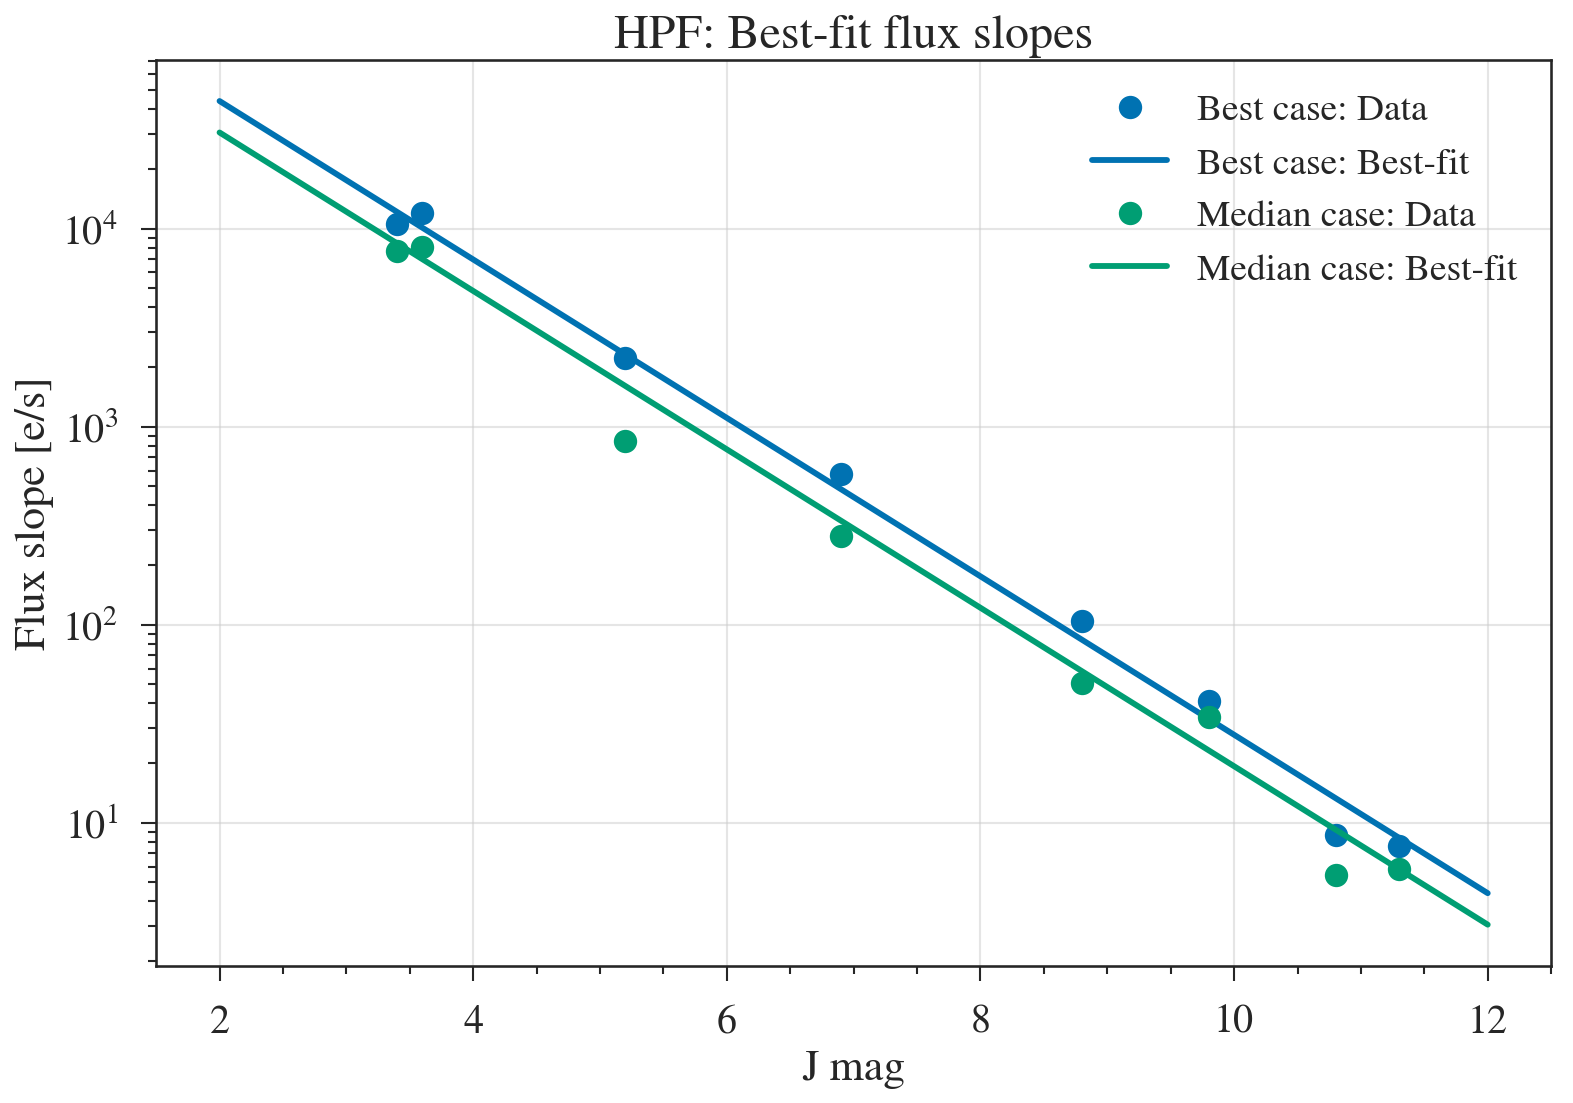

In [42]:
# Plotting
fig, ax = plt.subplots(figsize=(12,8),dpi=150)

cp = sns.color_palette("colorblind") 

#################################
# Best case
ax.plot(df.jmag,df['slope18_best'],marker = 'o',lw=0,color=cp[0],label='Best case: Data')
# Fit
mref1 = fit_slope(df.jmag.values,df.slope18_best)
print('Best-fit Constant mref for best case = {:0.2f}'.format(mref1))
xmod = np.linspace(2.,12,100)
ymod = slope_model(mref1,xmod)
ax.plot(xmod,ymod,color=cp[0],label='Best case: Best-fit')

#################################
# Median case
ax.plot(df.jmag,df['slope18_med'],marker = 'o',lw=0,color=cp[1],label='Median case: Data')
# Fit
mref2 = fit_slope(df.jmag.values,df.slope18_med)
print('Best-fit Constant mref for median case = {:0.2f}'.format(mref2))
xmod = np.linspace(2.,12,100)
ymod = slope_model(mref2,xmod)
ax.plot(xmod,ymod,color=cp[1],label='Median case: Best-fit')

ax.set_yscale('log')
ax.set_xlabel('J mag')
ax.set_ylabel('Flux slope [e/s]')
ax.grid(lw=1.,alpha=0.5)
ax.minorticks_on()
ax.set_title('HPF: Best-fit flux slopes')
ax.legend(loc='upper right',fontsize=18);
fig.savefig('../plots/best_fit_flux_slopes.png',dpi=200)

# HPF SNR Plots

Let's define a few useful functions first:

In [98]:
def slope_variance(b,n,t_g,g,m,s_read):
    """
    Calculate the slope variance in electrons^2/s^2/2D-pixel
    
    INPUT:
        b: flux in electrons/s/pixel
        n: number of reads
        t_g: time per read in s
        g: gain in electrons/count
        m: number of read groups (1)
        s_read: readout noise in electrons/2d-pixel
        
    OUTPUT:
        The slope variance in electrons^2/s^2/2D-pixel
        
    NOTES:
        # Equation 7 in JWST M. Robberto Technical Report:
        https://jwst.stsci.edu/files/live/sites/jwst/files/home/instrumentation/technical%20documents/JWST-STScI-002161.pdf
    """
    poisson_term = (6./5.)*((n**2.+1.)/(n*(n**2.-1.)))*(b/t_g)
    read_and_digitization_term = (12./(n*(n**2.-1.)*(t_g**2.)))*((s_read**2.)/m + (g**2.)*(m**2.)/12.)
    return poisson_term + read_and_digitization_term

def hpf_ramp_variance(flux,t_exp,number_of_crossdisp_pixels=10.):
    """
    Get the total HPF ramp variance for a given flux array including readoutnoise
    
    INPUT:
        flux: flux in electrons/1Dpix
        t_exp: exposure time in s
        number_of_crossdisp_pixels: number of pixels in the cross-dispersion direction in 2Dpix/1Dpix
    
    OUTPUT:
        var_e: the variance of the total electrons summed up across the dispersion order per 1D extracted pixel.
    """
    b = flux/(t_exp*number_of_crossdisp_pixels) # electrons/s/2Dpixel
    
    # HPF Specific Config
    m = 1. # 1x group
    g = 2.5 # electrons/count
    t_g = 10.485 # s
    #n = int(t_exp/t_g) # only use if want discrete reads
    n = t_exp/t_g
    s_read = 10.5 # electrons/pixel in HPF 1D
    
    var_b = slope_variance(b=b,n=n,t_g=t_g,g=g,m=m,s_read=s_read)
    var_b_texp = var_b*(t_exp**2.) # variance of total number of electrons / pix
    var_b_texp_tot = var_b_texp * number_of_crossdisp_pixels # not squared as the sigma goes as sqrt(number_of_crossdisp_pixels)
    var_e = var_b_texp_tot # this is the variance of the total electrons per 1D extracted pixel
    return var_e
    #return var_b

def flux_in_electrons(m,t_exp,mref):
    """
    Get the flux in electrons for a given exposure time and magnitude
    
    INPUT:
        t_exp: exposure time in s
        m: magnitude of star
        C: fixed constant
    
    OUTPUT:
        flux: flux in electrons
    """
    return slope_model(mref,m)*t_exp

def hpf_snr(m,t_exp,mref):
    """
    HPF SNR calculator including read noise
    """
    flux = flux_in_electrons(m,t_exp,mref)
    variance = hpf_ramp_variance(flux,t_exp)
    return flux/np.sqrt(variance)    

# SNR as a function of J-mag and exposure time

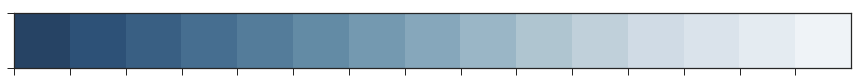

In [66]:
# Lets define a useful color palette
cp = sns.color_palette('Blues_r',15,desat=0.5)
sns.palplot(cp)

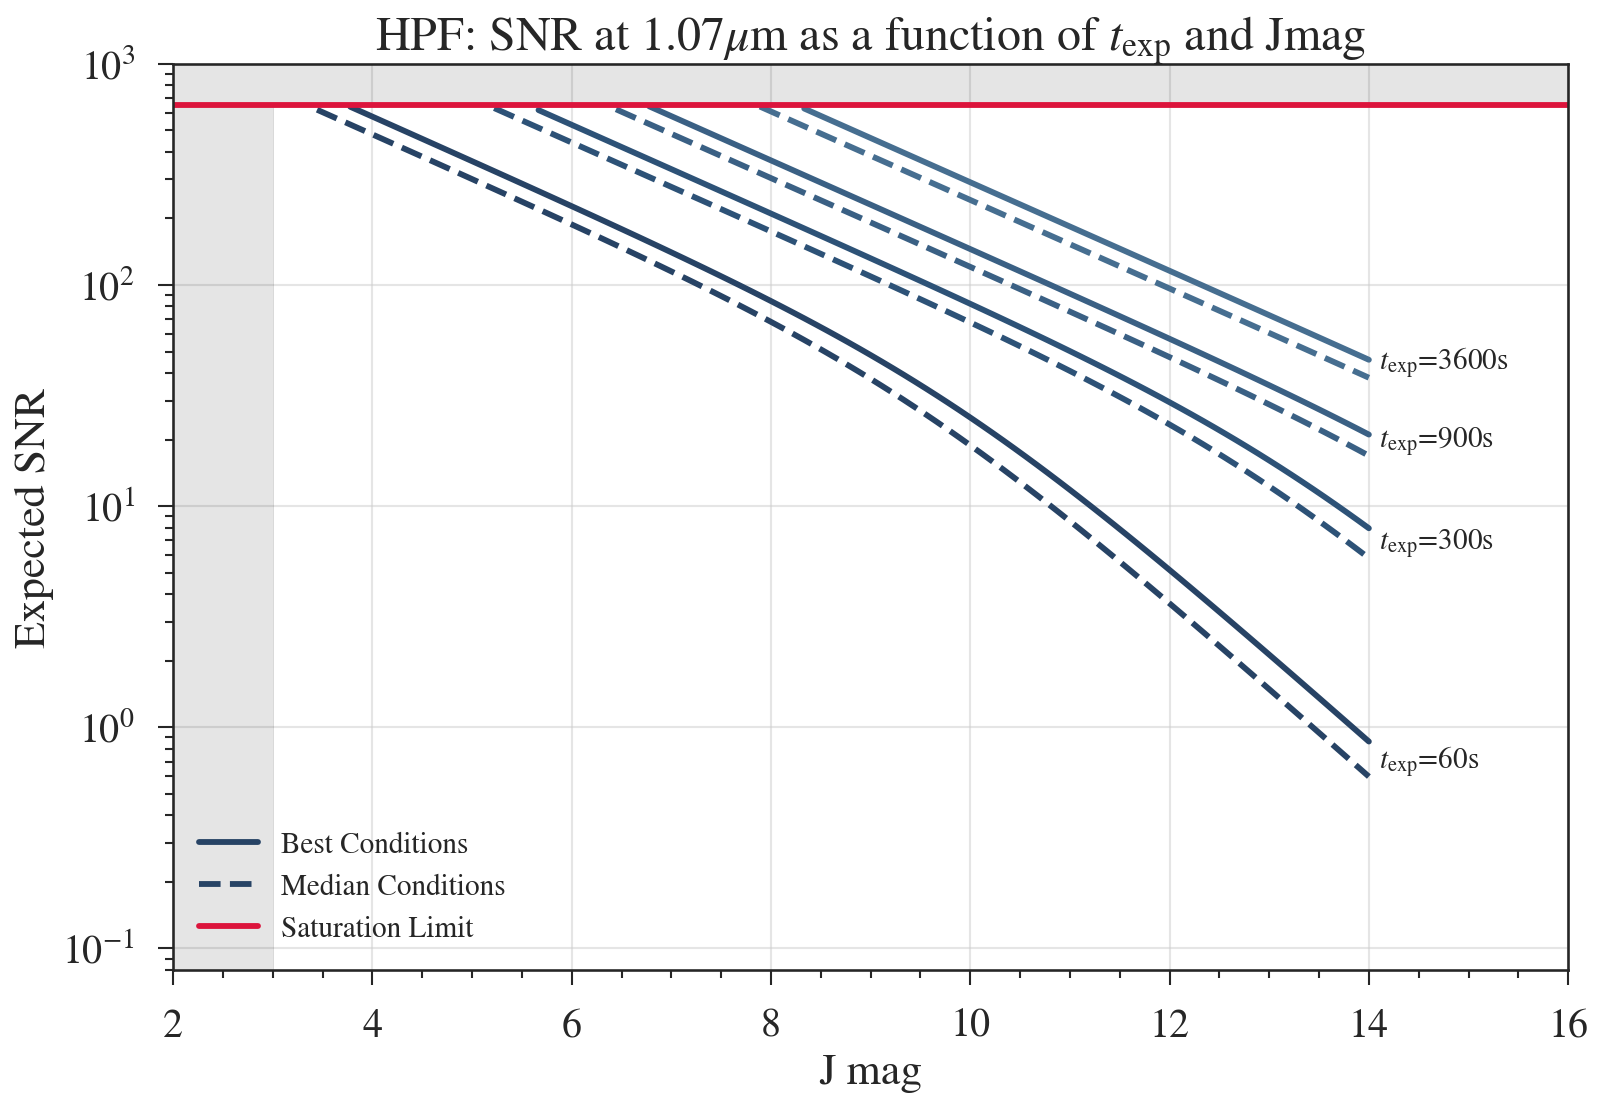

In [67]:
fig, ax = plt.subplots(figsize=(12,8),dpi=150)

# Saturation happens at ~SNR=650
SNRMAX = 650.
#################################
# Best case
mm = np.linspace(3.,14,100)

# Plot for a few number of exposure times
EXPTIMES = [60.,300.,900.,3600.]

for i in range(len(EXPTIMES)):
    # Only label first lines
    if i == 0:
        lab1 = 'Best Conditions'
        lab2 = 'Median Conditions'
    else:
        lab1 = None
        lab2 = None
    t_exp = EXPTIMES[i]
    # Best case
    snr = hpf_snr(mm,t_exp,mref=13.63)
    mask = snr < SNRMAX
    ax.plot(mm[mask],snr[mask],1.,color=cp[i],label=lab1)
    # Median case
    snr = hpf_snr(mm,t_exp,mref=13.23)
    mask = snr < SNRMAX
    ax.plot(mm[mask],snr[mask],1.,color=cp[i],ls='--',label=lab2)
    ax.text(14.1,snr[-1]*1.1,s='$t_{\mathrm{exp}}$='+str(int(t_exp))+"s",fontsize=14,label=lab1)

xlim = (2.,16.)
ax.set_xlim(xlim)
ylim = (0.08,1000.)
ax.set_ylim(ylim)
ax.fill_between(np.linspace(xlim[0],3.),ylim[0],SNRMAX,color='black',alpha=0.1)
ax.fill_between(np.linspace(xlim[0],xlim[1]),SNRMAX,ylim[1],color='black',alpha=0.1)
ax.axhline(y=SNRMAX,color='crimson',label='Saturation Limit')
lines, labels = ax.get_legend_handles_labels()
lines, labels = np.array(lines), np.array(labels)
ax.legend(lines[[0,2,-1]],labels[[0,2,-1]],fontsize=14)

ax.set_yscale('log')
ax.set_xlabel('J mag')
ax.set_ylabel('Expected SNR')
ax.grid(lw=1.,alpha=0.5)
ax.minorticks_on()
ax.set_title('HPF: SNR at 1.07$\mu$m as a function of $t_{\mathrm{exp}}$ and Jmag')
fig.savefig('../plots/snr_jmag_texp.png',dpi=200)

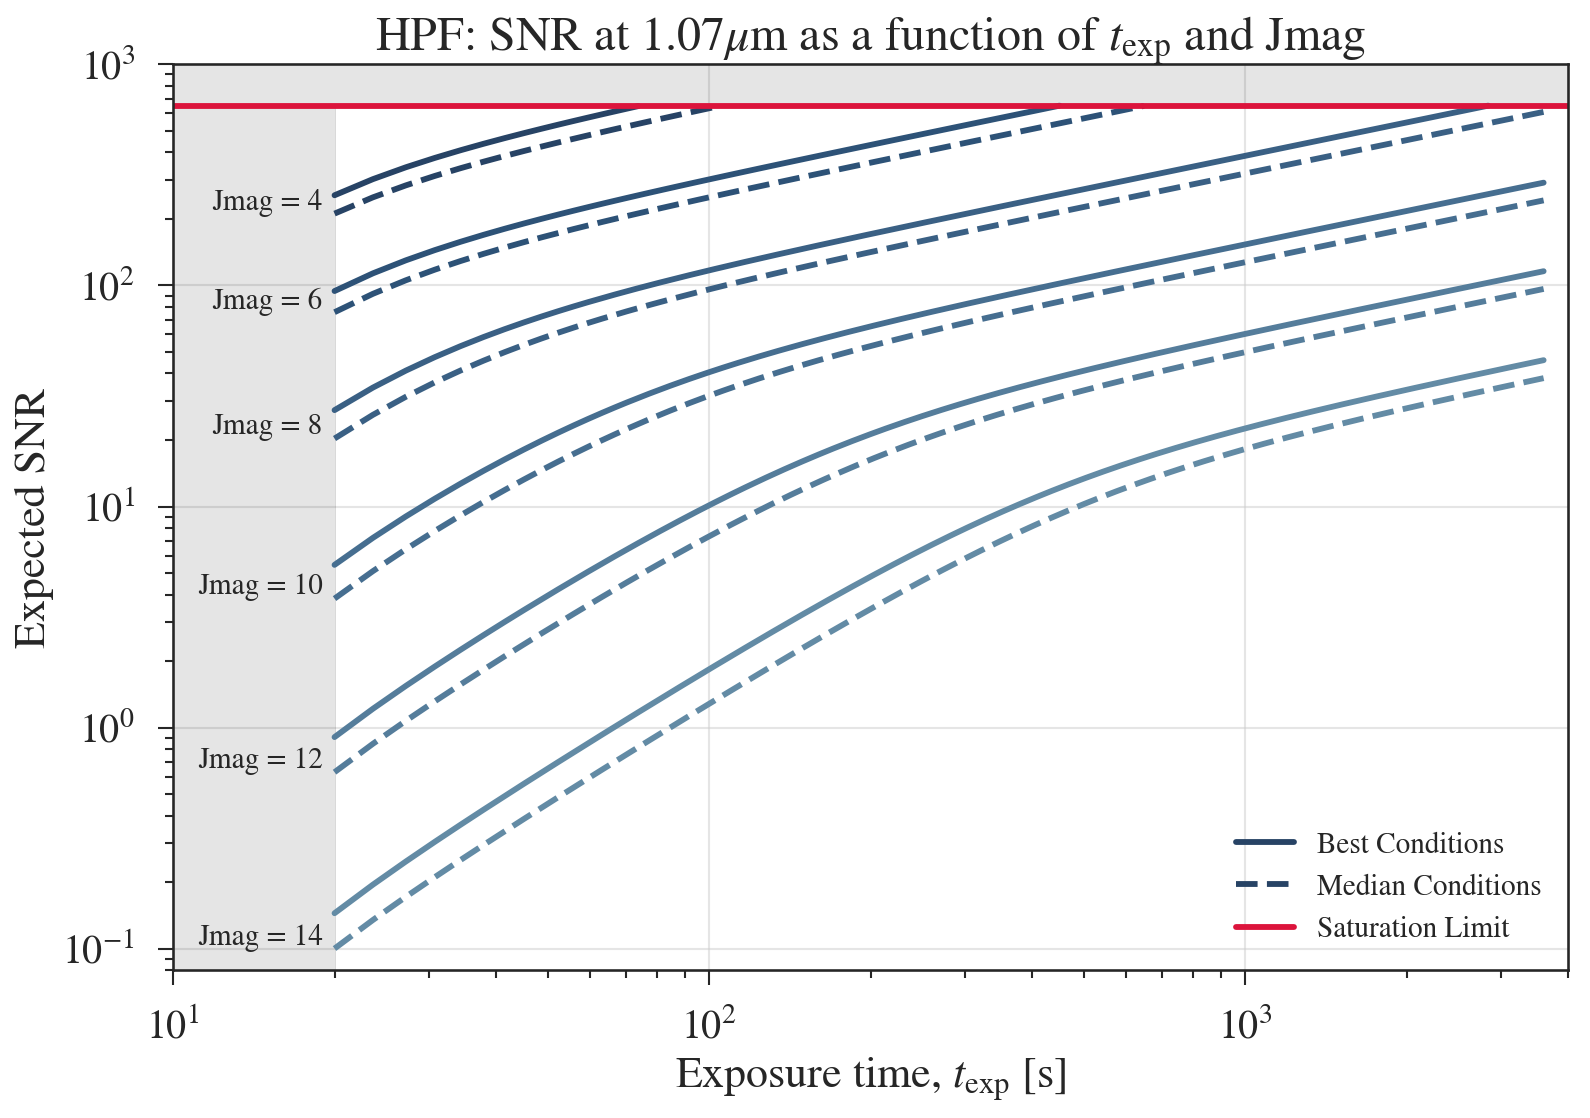

In [68]:
fig, ax = plt.subplots(figsize=(12,8),dpi=150)

# Saturation happens at ~SNR=650
SNRMAX = 650.
#################################
# Best case
t_exp = np.linspace(20.,3600,1000)

# plot for a few given magnitudes
MAGS = [4,6,8,10,12,14]
for i in range(len(MAGS)):
    # Only put legend on first magnitudes
    if i == 0:
        lab1 = 'Best Conditions'
        lab2 = 'Median Conditions'
    else: 
        lab1 = None
        lab2 = None
    mm = MAGS[i]
    snr = hpf_snr(mm,t_exp,mref=13.63)
    mask = snr < SNRMAX
    ax.plot(t_exp[mask],snr[mask],1.,color=cp[i],label=lab1)
    snr = hpf_snr(mm,t_exp,mref=13.23)
    mask = snr < SNRMAX
    ax.plot(t_exp[mask],snr[mask],1.,color=cp[i],ls='--',label=lab2)
    ax.annotate(s='Jmag = {}'.format(mm),xy=(t_exp[0]-1.,snr[0]*1.3),ha='right',va='top',fontsize=14)

xlim = (10.,4000.)
ax.set_xlim(xlim)
ylim = (0.08,1000.)
ax.set_ylim(ylim)
ax.fill_between(np.linspace(xlim[0],20.),ylim[0],SNRMAX,color='black',alpha=0.1)
ax.fill_between(np.linspace(xlim[0],xlim[1]),SNRMAX,ylim[1],color='black',alpha=0.1)
ax.axhline(y=SNRMAX,color='crimson',label='Saturation Limit')
lines, labels = ax.get_legend_handles_labels()
lines, labels = np.array(lines), np.array(labels)
ax.legend(lines[[0,2,-1]],labels[[0,2,-1]],fontsize=14)
ax.set_yscale('log')
ax.set_xlabel('Exposure time, $t_{\mathrm{exp}}$ [s]')
ax.set_xscale('log')
ax.set_ylabel('Expected SNR')
ax.grid(lw=1.,alpha=0.5)
ax.minorticks_on()
ax.set_title('HPF: SNR at 1.07$\mu$m as a function of $t_{\mathrm{exp}}$ and Jmag')
fig.savefig('../plots/snr_texp_jmag.png',dpi=200)